In [2]:
#Importing the libraries and packages
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from scipy import ndimage
from dnn_app_utils_v3 import *
from PIL import Image
import os

In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset loading

In [3]:
train_x_orig, train_y, test_x_orig,test_y,classes = load_data()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../datasets/train_catvnoncat.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

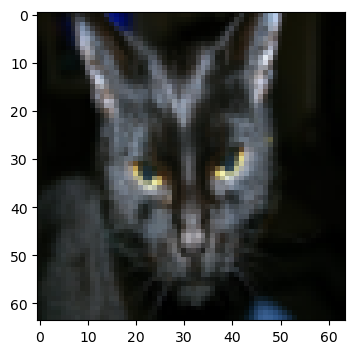

In [22]:
index = 25
plt.imshow(train_x_orig[index])

# Exploring the data

In [23]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

In [24]:
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


# Reshaping and standardizing the data

In [27]:
train_x_flattened = train_x_orig.reshape(train_x_orig.shape[0],-1).T
test_x_flattened = test_x_orig.reshape(test_x_orig.shape[0],-1).T

In [29]:
train_x_flattened = train_x_flattened/255
test_x_flattened = test_x_flattened/255

# Architecture of the model 

1) A 2 layer Neural network will be built

2) An N layer neural network will be built

For the 2 layer neural network, the model can be summarized as ***Input*** -> Liner -> Relu -> Linear -> Sigmoid -> Output

The input is a 64 x 64 x 3 image flattened into a vector of size 12288,1

The corresponding vector corresponding feature vector x1 .. .x12287 is multiplied by a weight matrix W of size n[l],12288

Then repeat the same process

You multiply the resulting vector by W2 and add your intercept

Finally you take the sigmoid of the result and classify based on the threshold (0.5)

For the L layer neural network, the model can be summarized as [Linear -> Relu] (L-1 times) -> Linear -> Sigmoid

The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
The corresponding vector: 
 is then multiplied by the weight matrix 
 and then you add the intercept 
. The result is called the linear unit.
Next, you take the relu of the linear unit. This process could be repeated several times for each 
 depending on the model architecture.
Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

In [31]:
n_x = 12288
n_h = 7
n_y = 1
layer_dims = (n_x,n_h,n_y)

In [32]:
def initialize_parameters(n_x,n_h,n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h,n_x)
    W2 = np.random.randn(n_y,n_h)
    b1 = np.zeros((n_h,1))
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters


In [33]:
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
b1 = [[0.]
 [0.]]
W2 = [[ 1.74481176 -0.7612069 ]]
b2 = [[0.]]


In [34]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    paramters = {}
    L = len(layer_dims)
    for l in range(1,L):
        paramters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        paramters['b' + str(l)] = np.zeros((layer_dims[l],1))
    return parameters


In [35]:
def linear_forward(A,W,b):
    Z = np.dot(W,A)+b
    cache = (A,W,b)
    return Z,cache

In [37]:
def linear_activation_forward(A_prev, W,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache= sigmoid(Z)
    elif activation == "relu":
        Z,linear_cache = linear_forward(A_prev, W,b)
        A,activation_cache = relu(Z)
    cache = (linear_cache,activation_cache)
    return A,cache

In [38]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters)//2
    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev, parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
    
    AL,cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    return AL,caches

In [39]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    cost = (-1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T))
    cost.squeeze(cost)
    return cost

In [40]:
def linear_backward(dZ,cache):
    A_prev,W,b =cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis =1,keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev,dW,db

In [41]:
def linear_activation_backward(dA, cache, activation):
    linear_cache,activation_cache = cache
    if activation == "relu":
        dz = relu_backward(dA,activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
    dA_prev,dW,db = linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [42]:
# GRADED FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1] # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [43]:
def update_paramters(parameters,grads,learning_rate):
    L = len(parameters)//2

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    ### END CODE HERE ###
    return parameters